In [94]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [95]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [96]:
len(words)

32033

In [97]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [98]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
   #  print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [99]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [154]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [100]:
C = torch.randn((27, 2))

In [101]:
# C[5] # same as this idea F.one_hot(torch.tensor(5), num_classes=27).float() @ C

In [102]:
emb = C[X]
emb.shape


torch.Size([228146, 3, 2])

In [103]:
W1 = torch.randn((6, 100)) # 3 * 2
b1 = torch.randn(100)

In [104]:
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1) # hardcoded for block size 3

In [105]:
# torch.cat(torch.unbind(emb, dim=1), 1).shape (another way to do it) inefficient

In [106]:
h = emb.view(-1, 6) @ W1 + b1 # -1 is a wildcard for any dimension and will be inferred, this method just changes how the memory is described
h.shape
h

tensor([[ 3.0425,  1.0422, -0.2727,  ...,  0.6365, -0.7112, -1.0720],
        [ 1.8970,  2.3530,  0.8863,  ...,  2.2927, -0.3997, -0.7480],
        [ 1.8884, -0.9833, -2.1143,  ..., -2.2918,  4.1040, -3.9457],
        ...,
        [-0.0811, -2.0089,  0.2803,  ...,  7.2240,  2.0098, -2.8869],
        [ 4.3223, -5.4265,  1.8333,  ...,  1.0818,  7.0374, -6.3111],
        [-0.8554,  6.1808, -2.0468,  ...,  3.7262,  1.5502,  1.7389]])

In [107]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [108]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [109]:
counts = logits.exp()

In [110]:
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [111]:
prob[torch.arange(32), Y] # untrained but ideally all 1s meaning predicting each character correctly

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

# redone for neatness all together now


In [155]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [190]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [191]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [192]:
for p in parameters:
    p.requires_grad = True


In [159]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponential decay
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [200]:
for i in range(50000):
    # mini-batch contruction
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward() # to populate the gradients
    
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr  * p.grad
        
    # track progress
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)


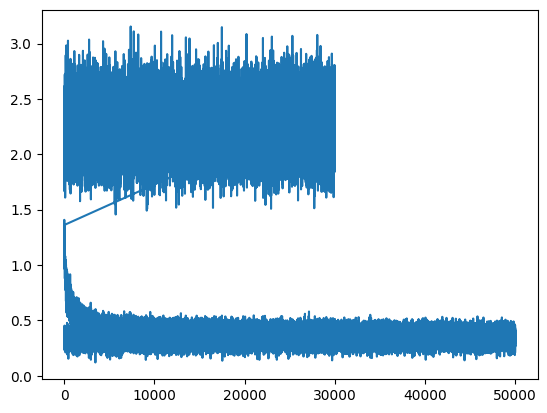

In [201]:
plt.plot(stepi, lossi)

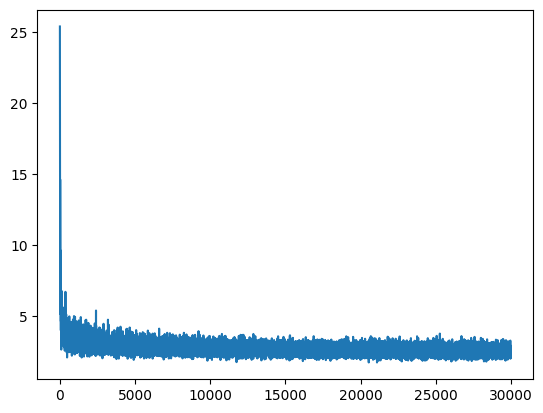

In [171]:
plt.plot(stepi, lossi)

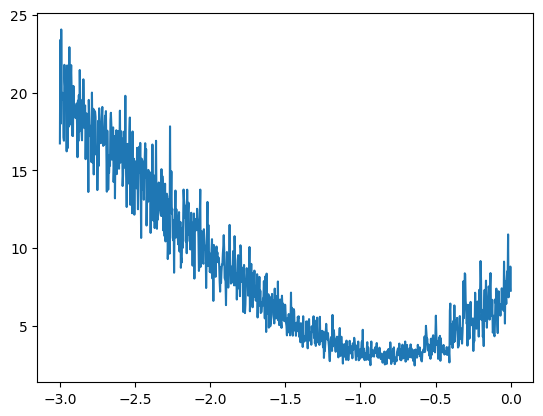

In [130]:
plt.plot(lri, lossi) # shows that 0.1 is a good learning rate

In [202]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1693, grad_fn=<NllLossBackward0>)

In [203]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1974, grad_fn=<NllLossBackward0>)

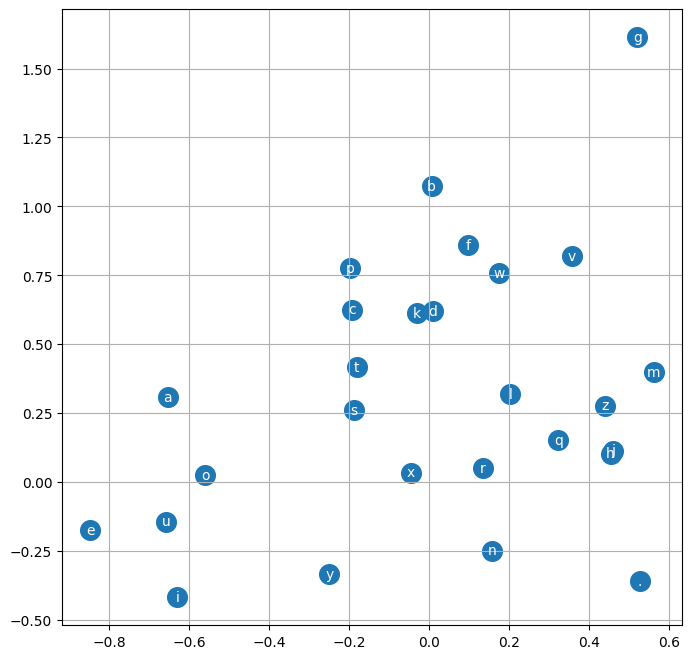

In [189]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters because we only have 2 dimensions
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor') # this graph is so cooool, like aeiou

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10% 

In [204]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [205]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))


mora.
kayah.
seer.
nihah.
larethaniendrari.
aderydieliigh.
parelle.
eliestanar.
kayzion.
karin.
shuber.
shiriel.
kendreelynn.
nophirous.
kynder.
yarleyel.
yuma.
myston.
mahia.
calynn.
